Running on: cuda
Unfreezing: final_conv.conv.weight
Unfreezing: final_conv.bn.weight
Unfreezing: final_conv.bn.bias
Unfreezing: head.fc.weight
Unfreezing: head.fc.bias
Epoch 1: Train Acc=0.6636, Val Acc=0.7622
Saved model.
Epoch 2: Train Acc=0.7842, Val Acc=0.8080
Saved model.
Epoch 3: Train Acc=0.8178, Val Acc=0.8359
Saved model.
Epoch 4: Train Acc=0.8373, Val Acc=0.8490
Saved model.
Epoch 5: Train Acc=0.8541, Val Acc=0.8578
Saved model.
Epoch 6: Train Acc=0.8652, Val Acc=0.8670
Saved model.
Epoch 7: Train Acc=0.8737, Val Acc=0.8726
Saved model.
Epoch 8: Train Acc=0.8824, Val Acc=0.8785
Saved model.
Epoch 9: Train Acc=0.8896, Val Acc=0.8842
Saved model.
Epoch 10: Train Acc=0.8953, Val Acc=0.8836
No improvement. Early stop counter: 1/10
Epoch 11: Train Acc=0.9007, Val Acc=0.8876
Saved model.
Epoch 12: Train Acc=0.9054, Val Acc=0.8899
Saved model.
Epoch 13: Train Acc=0.9122, Val Acc=0.8911
Saved model.
Epoch 14: Train Acc=0.9148, Val Acc=0.8946
Saved model.
Epoch 15: Train Acc=0.9180, V

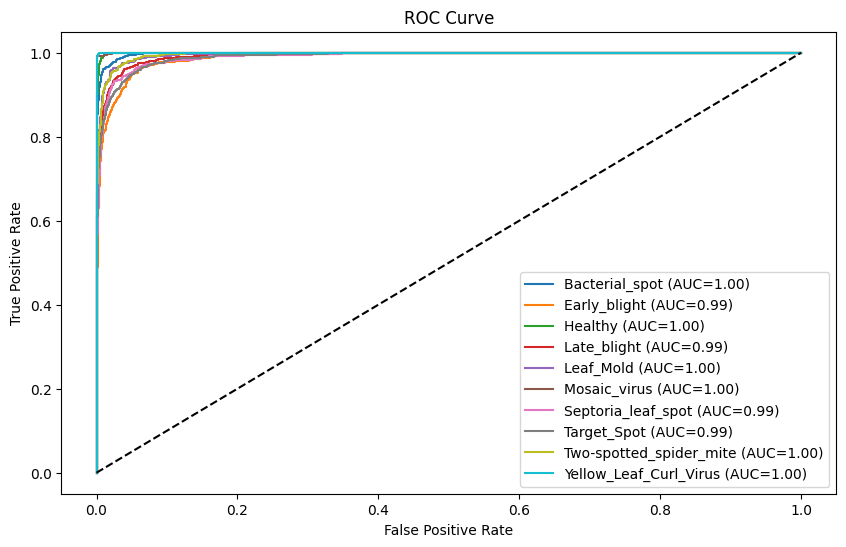

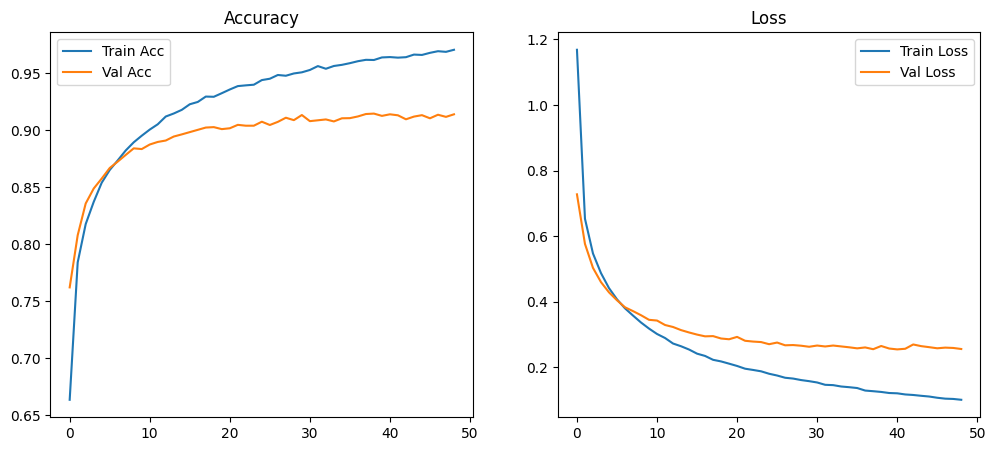

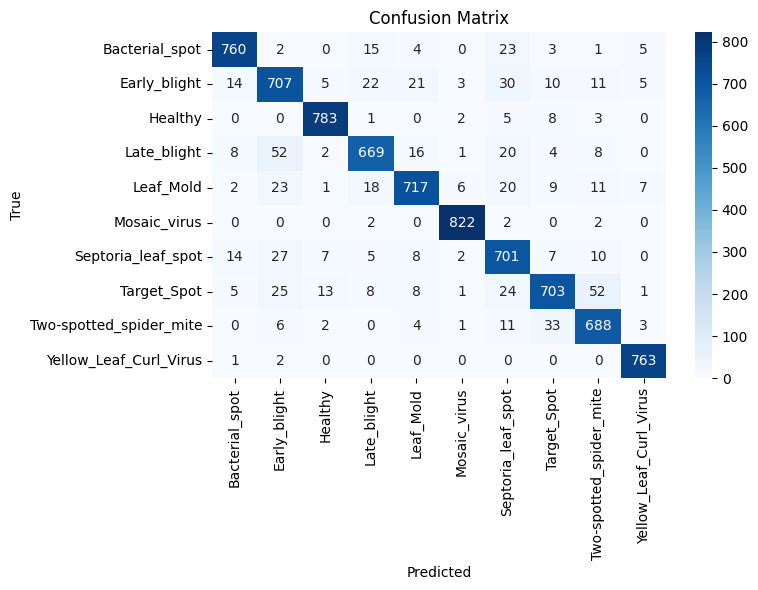

In [1]:
# MobileViT-XXS 
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Settings
dataset_dir = "./Tomato"
img_size = 224
batch_size = 96
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

# Dataset
full_dataset = datasets.ImageFolder(dataset_dir, transform=train_transforms)
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
class_names = train_loader.dataset.dataset.classes

# Model: mobilevit_xxs
model = timm.create_model("mobilevit_xxs", pretrained=True, num_classes=num_classes)
model.to(device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 5 layers
all_layers = list(model.named_parameters())
for name, param in all_layers[-5:]:
    param.requires_grad = True
    print(f"Unfreezing: {name}")

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# Early Stopping
early_stop_patience = 10
early_stop_counter = 0

# Training
epochs = 200
best_val_acc = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
start_time = time.time()

for epoch in range(epochs):
    model.train()
    train_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    train_acc = correct / len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, correct = 0.0, 0
    y_probs, y_true = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            y_probs.extend(outputs.softmax(1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    val_acc = correct / len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, "./mobilevit_xxs_model.pth")
        early_stop_counter = 0
        print("Saved model.")
    else:
        early_stop_counter += 1
        print(f"No improvement. Early stop counter: {early_stop_counter}/{early_stop_patience}")
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

print(f"Training Time: {(time.time() - start_time) / 60:.2f} minutes")

# Evaluation
y_probs = np.array(y_probs)
y_preds = np.argmax(y_probs, axis=1)
y_true = np.array(y_true)

conf_matrix = confusion_matrix(y_true, y_preds)

print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:")
print(classification_report(y_true, y_preds, target_names=class_names))

# ROC Curve
y_true_1hot = np.eye(num_classes)[y_true]
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_1hot[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Training History Plot
def plot_history(hist):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist['train_acc'], label='Train Acc')
    plt.plot(hist['val_acc'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(hist['train_loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history(history)

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


Running on: cuda
Unfreezing: final_conv.conv.weight
Unfreezing: final_conv.bn.weight
Unfreezing: final_conv.bn.bias
Unfreezing: head.fc.weight
Unfreezing: head.fc.bias
Epoch 1: Train Acc=0.6538, Val Acc=0.7478
Saved new best model.
Epoch 2: Train Acc=0.7706, Val Acc=0.7855
Saved new best model.
Epoch 3: Train Acc=0.8058, Val Acc=0.8081
Saved new best model.
Epoch 4: Train Acc=0.8255, Val Acc=0.8237
Saved new best model.
Epoch 5: Train Acc=0.8430, Val Acc=0.8320
Saved new best model.
Epoch 6: Train Acc=0.8588, Val Acc=0.8460
Saved new best model.
Epoch 7: Train Acc=0.8703, Val Acc=0.8535
Saved new best model.
Epoch 8: Train Acc=0.8817, Val Acc=0.8556
Saved new best model.
Epoch 9: Train Acc=0.8869, Val Acc=0.8580
Saved new best model.
Epoch 10: Train Acc=0.8961, Val Acc=0.8665
Saved new best model.
Epoch 11: Train Acc=0.9044, Val Acc=0.8681
Saved new best model.
Epoch 12: Train Acc=0.9073, Val Acc=0.8692
Saved new best model.
Epoch 13: Train Acc=0.9130, Val Acc=0.8761
Saved new best mod

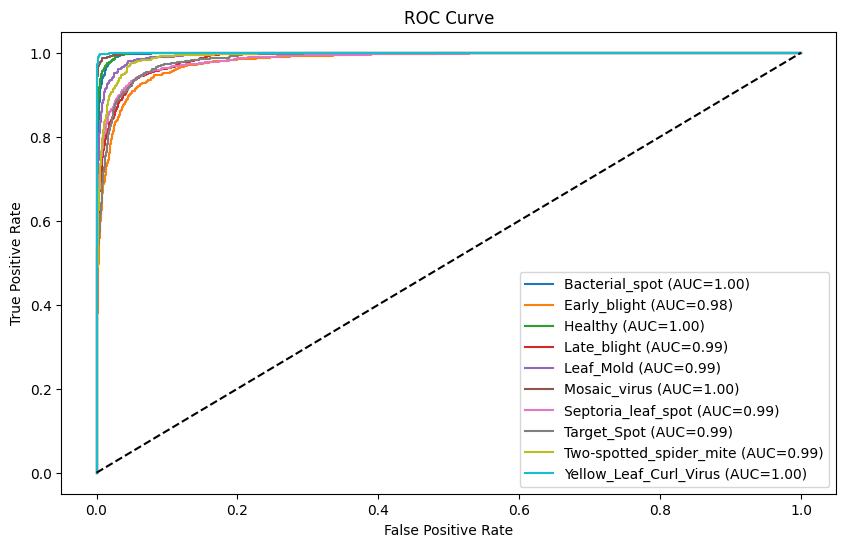

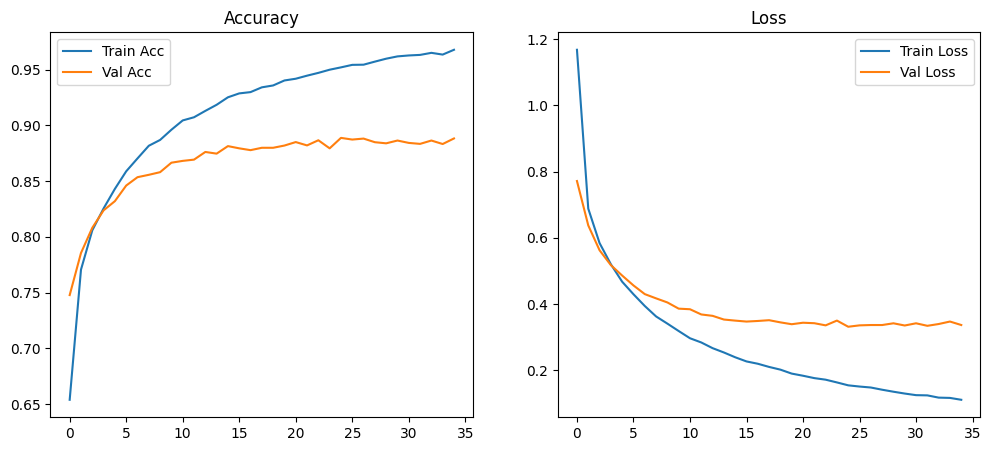

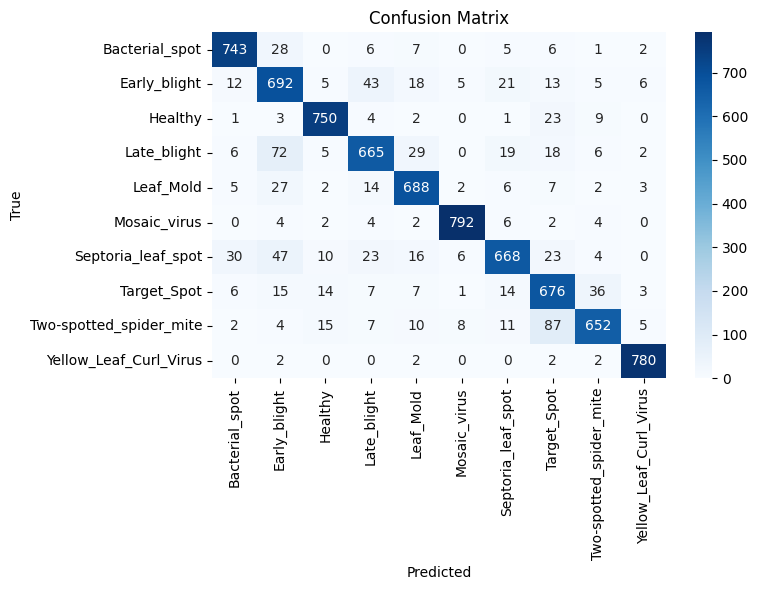

In [2]:
# mobilevit_xs
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Settings
dataset_dir = "./Tomato"
img_size = 224
batch_size = 96
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])
# Dataset
full_dataset = datasets.ImageFolder(dataset_dir, transform=train_transforms)
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transforms
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
class_names = train_loader.dataset.dataset.classes
# Model
model = timm.create_model("mobilevit_xs", pretrained=True, num_classes=num_classes)
model.to(device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 5 layers
all_layers = list(model.named_parameters())
for name, param in all_layers[-5:]:
    param.requires_grad = True
    print(f"Unfreezing: {name}")

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# Early Stopping
early_stop_patience = 10
early_stop_counter = 0

# Training
epochs = 200
best_val_acc = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
start_time = time.time()

for epoch in range(epochs):
    model.train()
    train_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    train_acc = correct / len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, correct = 0.0, 0
    y_probs, y_true = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            y_probs.extend(outputs.softmax(1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    val_acc = correct / len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Learning Rate Scheduler Step
    scheduler.step(val_acc)

    # Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, "./mobilevit_xs_model.pth")
        early_stop_counter = 0
        print("Saved new best model.")
    else:
        early_stop_counter += 1
        print(f"No improvement. Early stop counter: {early_stop_counter}/{early_stop_patience}")
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

print(f"Training Time: {(time.time() - start_time) / 60:.2f} minutes")

# Evaluation
y_probs = np.array(y_probs)
y_preds = np.argmax(y_probs, axis=1)
y_true = np.array(y_true)

conf_matrix = confusion_matrix(y_true, y_preds)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:")
print(classification_report(y_true, y_preds, target_names=class_names))

# ROC Curve
y_true_1hot = np.eye(num_classes)[y_true]
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_1hot[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Training History Plot
def plot_history(hist):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist['train_acc'], label='Train Acc')
    plt.plot(hist['val_acc'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(hist['train_loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history(history)

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Running on: cuda
Unfreezing: final_conv.conv.weight
Unfreezing: final_conv.bn.weight
Unfreezing: final_conv.bn.bias
Unfreezing: head.fc.weight
Unfreezing: head.fc.bias
Epoch 1: Train Acc=0.6930, Val Acc=0.7834
Saved new best model.
Epoch 2: Train Acc=0.8104, Val Acc=0.8277
Saved new best model.
Epoch 3: Train Acc=0.8468, Val Acc=0.8468
Saved new best model.
Epoch 4: Train Acc=0.8721, Val Acc=0.8630
Saved new best model.
Epoch 5: Train Acc=0.8890, Val Acc=0.8720
Saved new best model.
Epoch 6: Train Acc=0.9055, Val Acc=0.8810
Saved new best model.
Epoch 7: Train Acc=0.9162, Val Acc=0.8856
Saved new best model.
Epoch 8: Train Acc=0.9272, Val Acc=0.8948
Saved new best model.
Epoch 9: Train Acc=0.9342, Val Acc=0.8978
Saved new best model.
Epoch 10: Train Acc=0.9427, Val Acc=0.9039
Saved new best model.
Epoch 11: Train Acc=0.9516, Val Acc=0.9046
Saved new best model.
Epoch 12: Train Acc=0.9546, Val Acc=0.9055
Saved new best model.
Epoch 13: Train Acc=0.9625, Val Acc=0.9061
Saved new best mod

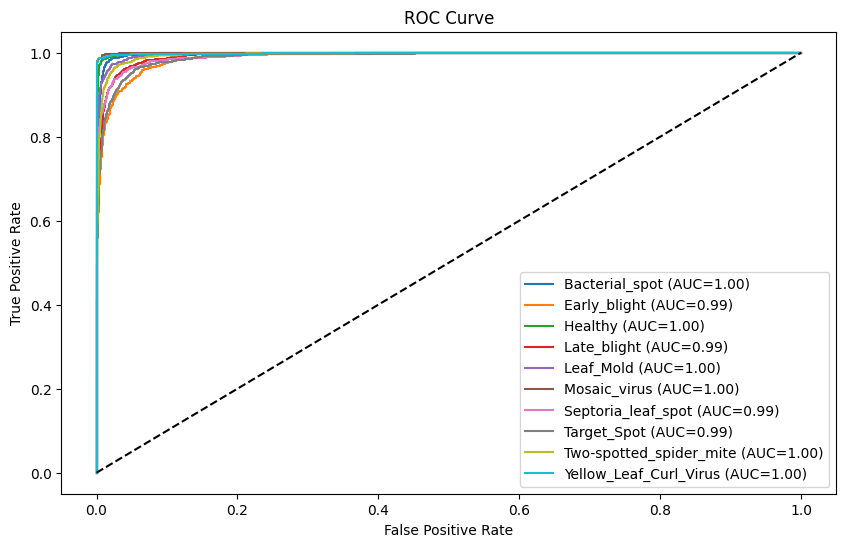

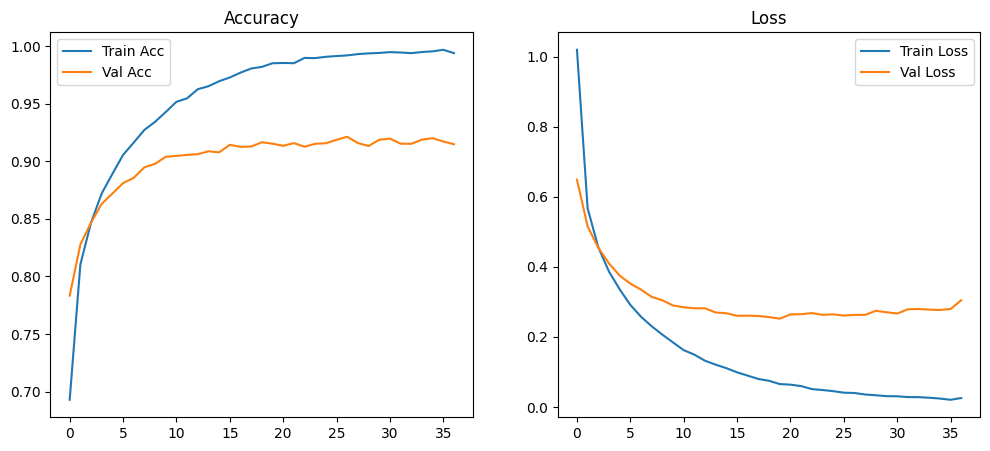

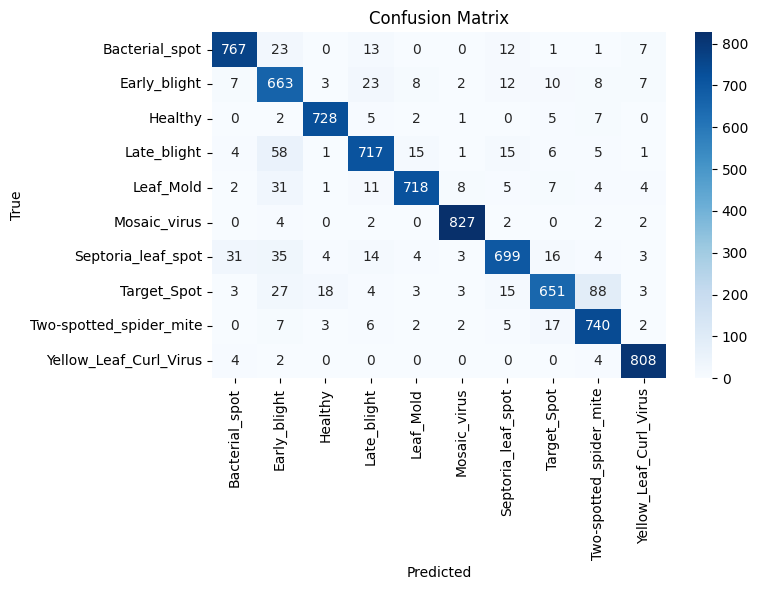

In [3]:
#mobilevit_s
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Settings
dataset_dir = "./Tomato"
img_size = 224
batch_size = 96
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])
# Dataset
full_dataset = datasets.ImageFolder(dataset_dir, transform=train_transforms)
val_size = int(0.2 * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
class_names = train_loader.dataset.dataset.classes

# Model
model = timm.create_model("mobilevit_s", pretrained=True, num_classes=num_classes)
model.to(device)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the last 5 layers
all_layers = list(model.named_parameters())
for name, param in all_layers[-5:]:
    param.requires_grad = True
    print(f"Unfreezing: {name}")

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# Early Stopping
early_stop_patience = 10
early_stop_counter = 0

# Training
epochs = 200
best_val_acc = 0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
start_time = time.time()

for epoch in range(epochs):
    model.train()
    train_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
    train_acc = correct / len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss, correct = 0.0, 0
    y_probs, y_true = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            y_probs.extend(outputs.softmax(1).cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    val_acc = correct / len(val_loader.dataset)
    val_loss /= len(val_loader.dataset)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    # Learning Rate Scheduler Step
    scheduler.step(val_acc)

    # Save Best Model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, "./mobilevit_Small_model.pth")
        early_stop_counter = 0
        print("Saved new best model.")
    else:
        early_stop_counter += 1
        print(f"No improvement. Early stop counter: {early_stop_counter}/{early_stop_patience}")
        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

print(f"Training Time: {(time.time() - start_time) / 60:.2f} minutes")

# Evaluation
y_probs = np.array(y_probs)
y_preds = np.argmax(y_probs, axis=1)
y_true = np.array(y_true)

conf_matrix = confusion_matrix(y_true, y_preds)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:")
print(classification_report(y_true, y_preds, target_names=class_names))

# ROC Curve
y_true_1hot = np.eye(num_classes)[y_true]
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_1hot[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Training History Plot
def plot_history(hist):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist['train_acc'], label='Train Acc')
    plt.plot(hist['val_acc'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(hist['train_loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history(history)


# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
